In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF,WhiteKernel,DotProduct
import pandas as pd
import torch



In [2]:
from snorkel import SnorkelSession
from snorkel.models import candidate_subclass
from snorkel.annotations import load_gold_labels
from snorkel.learning.pytorch import LSTM
from snorkel.annotations import load_marginals

from scipy import vstack
session = SnorkelSession()

In [3]:
ChemicalDisease = candidate_subclass('ChemicalDisease', ['chemical', 'disease'])

train = session.query(ChemicalDisease).filter(ChemicalDisease.split == 0).all()
dev = session.query(ChemicalDisease).filter(ChemicalDisease.split == 1).all()
test = session.query(ChemicalDisease).filter(ChemicalDisease.split == 2).all()

print('Training set:\t{0} candidates'.format(len(train)))
print('Dev set:\t{0} candidates'.format(len(dev)))
print('Test set:\t{0} candidates'.format(len(test)))

Training set:	8439 candidates
Dev set:	920 candidates
Test set:	4687 candidates


In [4]:
train_marginals = load_marginals(session, split=0)

In [5]:
from load_external_annotations import load_external_labels
load_external_labels(session, ChemicalDisease, split=2, annotator='gold')
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)
L_gold_dev = load_gold_labels(session,annotator_name='gold',split=1)

AnnotatorLabels created: 0


In [6]:
L_gold_dev.shape

(920, 1)

In [7]:
dev_labels = L_gold_dev.toarray().reshape(920,)
dev_labels[dev_labels == -1] = 0

In [8]:
full_train_set = train.copy()
full_train_set.extend(dev)
full_train_labels = list(train_marginals).copy()
full_train_labels.extend(dev_labels)
full_train_labels = np.array(full_train_labels)


In [9]:
len(full_train_set)
# why is it dropping so many data points?

9359

In [10]:
train_kwargs = {
    'lr':              0.01,
    'embedding_dim':   100,
    'hidden_dim':      100,
    'n_epochs':        100,
    'dropout':         0.5,
    'rebalance':       .25,
    'print_freq':      5,
    'seed':            1701,
    'num_layers':      5,
}

lstm = LSTM(n_threads=None)
lstm.train(full_train_set, full_train_labels, X_dev=dev, Y_dev=L_gold_dev, **train_kwargs)

[LSTM] Training model
[LSTM] n_train=4428  #epochs=100  batch size=64


/home/eric/anaconda3/envs/snorkel-extraction/lib/python3.6/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[LSTM] Epoch 1 (33.06s)	Average loss=0.692131	Dev F1=51.19
[LSTM] Epoch 6 (201.46s)	Average loss=0.664827	Dev F1=54.81
[LSTM] Epoch 11 (371.88s)	Average loss=0.659483	Dev F1=55.57
[LSTM] Epoch 16 (536.62s)	Average loss=0.657433	Dev F1=54.43
[LSTM] Epoch 21 (708.81s)	Average loss=0.656967	Dev F1=55.06
[LSTM] Epoch 26 (880.63s)	Average loss=0.656011	Dev F1=55.14
[LSTM] Epoch 31 (1048.63s)	Average loss=0.655951	Dev F1=55.85
[LSTM] Epoch 36 (1218.79s)	Average loss=0.656334	Dev F1=55.20
[LSTM] Epoch 41 (1387.00s)	Average loss=0.656591	Dev F1=55.28
[LSTM] Epoch 46 (1543.82s)	Average loss=0.655859	Dev F1=53.87
[LSTM] Epoch 51 (1712.02s)	Average loss=0.656006	Dev F1=54.58
[LSTM] Epoch 56 (1876.90s)	Average loss=0.656893	Dev F1=54.60
[LSTM] Epoch 61 (2045.54s)	Average loss=0.656408	Dev F1=53.03
[LSTM] Epoch 66 (2211.16s)	Average loss=0.655425	Dev F1=54.41
[LSTM] Epoch 71 (2380.00s)	Average loss=0.655792	Dev F1=53.80
[LSTM] Epoch 76 (2549.52s)	Average loss=0.656323	Dev F1=52.85
[LSTM] Epoch 81 (

In [11]:
lstm.save('trained_on_all_5_layers')

[LSTM] Model saved as <trained_on_all_5_layers>


In [12]:
lstm.score(test, L_gold_test)

(0.40300457217504898, 0.81344759393539878, 0.5389823105481546)

In [13]:
dev_features = lstm.feature_outputs(dev, 100)
train_features = lstm.feature_outputs(train, 100)

In [14]:
kernel_dev = RBF(1) + WhiteKernel(1)
kernel_train = RBF(1) + WhiteKernel(1)
gpc_dev = GaussianProcessClassifier(kernel = kernel_dev)
gpc_train = GaussianProcessClassifier(kernel = kernel_train)

In [15]:
train_labels = train_marginals.copy()
train_labels[train_labels > .5] = 1
train_labels[train_labels <= .5] = 0

In [16]:
gpc_dev.fit(dev_features.detach().numpy().reshape(920,10), dev_labels.reshape(920,))

GaussianProcessClassifier(copy_X_train=True,
                          kernel=RBF(length_scale=1) + WhiteKernel(noise_level=1),
                          max_iter_predict=100, multi_class='one_vs_rest',
                          n_jobs=None, n_restarts_optimizer=0,
                          optimizer='fmin_l_bfgs_b', random_state=None,
                          warm_start=False)

In [18]:
gpc_train.fit(train_features.detach().numpy().reshape(8439,10), train_labels.reshape(8439,))

GaussianProcessClassifier(copy_X_train=True,
                          kernel=RBF(length_scale=1) + WhiteKernel(noise_level=1),
                          max_iter_predict=100, multi_class='one_vs_rest',
                          n_jobs=None, n_restarts_optimizer=0,
                          optimizer='fmin_l_bfgs_b', random_state=None,
                          warm_start=False)

In [19]:
test_features = lstm.feature_outputs(test,100)

In [20]:
gpc_dev.kernel_

RBF(length_scale=2.39) + WhiteKernel(noise_level=0.000143)

In [21]:
gpc_train.kernel_

RBF(length_scale=1.23) + WhiteKernel(noise_level=1e-05)

In [23]:
ud = []
ut = []
preds_d = gpc_dev.predict_proba(test_features.detach().numpy().reshape(4687,10), uncertainty = ud)
preds_t = gpc_train.predict_proba(test_features.detach().numpy().reshape(4687,10), uncertainty = ut)

In [24]:
ud = ud[0]
ut = ut[0]

In [25]:
gpc_dev.classes_

array([0, 1], dtype=int64)

In [26]:
# what is the order of the probabilties? I think I was probably doingit backwards actually. 
pd, pt = [],[]
for x in preds_d:
    if x[0] > .5:
        pd.append(0)
    else:
        pd.append(1)
for x in preds_t:
    if x[0] > .5:
        pt.append(0)
    else:
        pt.append(1) 

In [27]:
ud = np.array(ud)
ut = np.array(ut)

In [28]:
ud.mean()

0.034926418807210514

In [29]:
ud.max()

0.33649372890799967

In [30]:
ut.mean()

0.021477884107130397

In [31]:
ut.max()

0.27254946909777167

In [33]:
test_y = L_gold_test.toarray().reshape(4687,)
test_y[test_y == -1] = 0

In [34]:
buckets = np.linspace(0,.4,15)

In [35]:
f1scores = []
for i in range(14):
    count = 0
    tp,fp,tn,fn = 0,0,0,0
    for j,p in enumerate(test_y):
        if ud[j] >= buckets[i] and ud[j] < buckets[i+1]:
            count += 1
            if p == 0 and pd[j] == 0:
                tn += 1
            elif p == 0 and pd[j] == 1:
                fp += 1
            elif p == 1 and pd[j] == 0:
                fn += 1
            else: #p == 1 and preds[j] == 1:
                tp += 1
    try:
        p = tp / (tp + fp)
    except:
        p = 0
    try:
        r = tp / (tp + fn)
    except: 
        r = 0
    try:
        f1 = 2/(1/p + 1/r)
    except:
        f1 = 0
    f1scores.append(f1)
    print ("Bucket {}: \n Count: {}\n F1: {}\n{},{},{},{}".format(buckets[i+1], count, f1,tp,fp,tn,fn))

Bucket 0.028571428571428574: 
 Count: 3083
 F1: 0.032520325203252036
18,15,1994,1056
Bucket 0.05714285714285715: 
 Count: 847
 F1: 0.5260663507109005
111,55,536,145
Bucket 0.08571428571428572: 
 Count: 468
 F1: 0.6968641114982578
100,37,281,50
Bucket 0.1142857142857143: 
 Count: 107
 F1: 0.2
2,0,89,16
Bucket 0.14285714285714288: 
 Count: 60
 F1: 0
0,0,51,9
Bucket 0.17142857142857143: 
 Count: 44
 F1: 0
0,0,39,5
Bucket 0.2: 
 Count: 24
 F1: 0
0,0,21,3
Bucket 0.2285714285714286: 
 Count: 24
 F1: 0
0,0,23,1
Bucket 0.2571428571428572: 
 Count: 12
 F1: 0
0,0,12,0
Bucket 0.28571428571428575: 
 Count: 8
 F1: 0
0,0,7,1
Bucket 0.31428571428571433: 
 Count: 8
 F1: 0
0,0,8,0
Bucket 0.34285714285714286: 
 Count: 2
 F1: 0
0,0,2,0
Bucket 0.37142857142857144: 
 Count: 0
 F1: 0
0,0,0,0
Bucket 0.4: 
 Count: 0
 F1: 0
0,0,0,0


<BarContainer object of 14 artists>

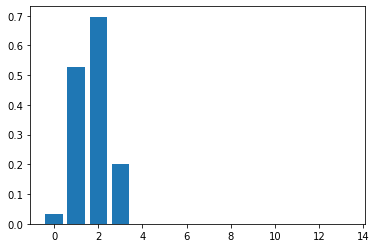

In [36]:
plt.bar(np.arange(len(f1scores)),f1scores)

In [37]:
f1scores = []
for i in range(14):
    count = 0
    tp,fp,tn,fn = 0,0,0,0
    for j,p in enumerate(test_y):
        if ut[j] >= buckets[i] and ut[j] < buckets[i+1]:
            count += 1
            if p == 0 and pt[j] == 0:
                tn += 1
            elif p == 0 and pt[j] == 1:
                fp += 1
            elif p == 1 and pt[j] == 0:
                fn += 1
            else: #p == 1 and preds[j] == 1:
                tp += 1
    try:
        p = tp / (tp + fp)
    except:
        p = 0
    try:
        r = tp / (tp + fn)
    except: 
        r = 0
    try:
        f1 = 2/(1/p + 1/r)
    except:
        f1 = 0
    f1scores.append(f1)
    print ("Bucket {}: \n Count: {}\n F1: {}\n{},{},{},{}".format(buckets[i+1], count, f1,tp,fp,tn,fn))

Bucket 0.028571428571428574: 
 Count: 4066
 F1: 0.49265341400172863
855,1379,1450,382
Bucket 0.05714285714285715: 
 Count: 212
 F1: 0.4782608695652174
22,20,142,28
Bucket 0.08571428571428572: 
 Count: 90
 F1: 0.6779661016949152
20,12,51,7
Bucket 0.1142857142857143: 
 Count: 96
 F1: 0.8428571428571429
59,22,15,0
Bucket 0.14285714285714288: 
 Count: 63
 F1: 0.7777777777777779
35,20,8,0
Bucket 0.17142857142857143: 
 Count: 74
 F1: 0.8495575221238939
48,17,9,0
Bucket 0.2: 
 Count: 64
 F1: 0.8113207547169812
43,19,1,1
Bucket 0.2285714285714286: 
 Count: 20
 F1: 0.8823529411764706
15,4,1,0
Bucket 0.2571428571428572: 
 Count: 1
 F1: 1.0
1,0,0,0
Bucket 0.28571428571428575: 
 Count: 1
 F1: 1.0
1,0,0,0
Bucket 0.31428571428571433: 
 Count: 0
 F1: 0
0,0,0,0
Bucket 0.34285714285714286: 
 Count: 0
 F1: 0
0,0,0,0
Bucket 0.37142857142857144: 
 Count: 0
 F1: 0
0,0,0,0
Bucket 0.4: 
 Count: 0
 F1: 0
0,0,0,0


<BarContainer object of 14 artists>

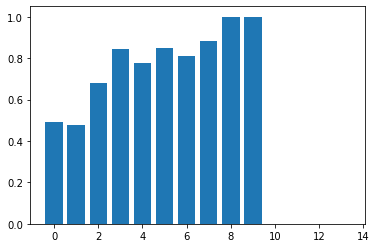

In [38]:
plt.bar(np.arange(len(f1scores)),f1scores)

In [39]:
tp,fp,tn,fn = 0,0,0,0
for j,p in enumerate (test_y):
        if p == 0 and pt[j] == 0:
            tn += 1
        elif p == 0 and pt[j] == 1:
            fp += 1
        elif p == 1 and pt[j] == 0:
            fn += 1
        else: #p == 1 and preds[j] == 1:
            tp += 1
try:
    p = tp / (tp + fp)
except:
    p = 0
try:
    r = tp / (tp + fn)
except: 
    r = 0
try:
    f1 = 2/(1/p + 1/r)
except:
    f1 = 0

In [40]:
f1

0.534923339011925

In [41]:
p

0.42399691358024694

In [42]:
dev_cov= np.matmul(dev_features.detach().numpy().reshape(920,10).transpose(), dev_features.detach().numpy().reshape(920,10))

In [43]:
np.linalg.svd(dev_cov)

(array([[-0.02454288,  0.16827181, -0.41313824,  0.17485811, -0.03450857,
         -0.23114122,  0.15643756,  0.25352567, -0.77410644,  0.1649783 ],
        [ 0.00619909, -0.50984198,  0.33170435,  0.24501438,  0.46111348,
          0.27290991,  0.44996852, -0.08444283, -0.24873303,  0.10671026],
        [-0.01535363, -0.03959166, -0.24530603,  0.26027584, -0.50752044,
          0.653611  ,  0.26826057,  0.29773378,  0.15116408, -0.04510142],
        [-0.01895368, -0.43400118, -0.07343823, -0.17658697,  0.21570389,
          0.13726819, -0.55691516,  0.6298123 , -0.04909476,  0.01041822],
        [ 0.02725045,  0.04966469,  0.58343935,  0.41767359, -0.27124715,
         -0.4156251 ,  0.06474347,  0.4683696 ,  0.10342843,  0.03687319],
        [ 0.02504365,  0.19075061,  0.53299421, -0.54584241, -0.28373045,
          0.31266025, -0.02052755,  0.01739667, -0.44920373, -0.01388809],
        [ 0.99808782,  0.00375422, -0.04917443, -0.00813287,  0.02061067,
          0.00714273,  0.0117745

In [44]:
gpc_dev.score(dev_features.detach().numpy().reshape(920,10), dev_labels)

0.68260869565217386

In [48]:
gpc_train.score(train_features.detach().numpy().reshape(8439,10), train_labels)

0.80874511198009247

In [49]:
gpc_dev.kernel_

RBF(length_scale=2.39) + WhiteKernel(noise_level=0.000143)

In [50]:
gpc_train.kernel_

RBF(length_scale=1.23) + WhiteKernel(noise_level=1e-05)